<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
<center>
Авторы материала: Ольга Дайховская (@aiho), Юрий Кашницкий (@yorko). 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 
## <center> Обучение без учителя

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/19oWnb5CxC5g-Zn45VWjuq_OP8YPCrn_g8Wq3aMaW2U4).

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
!pip install tqdm

    100% |████████████████████████████████| 61kB 2.7MB/s 


In [0]:
from io import StringIO

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
file_id_X_train = '1x0n6EI0y_onqo7rz_gFL_nO35HkvsxEC'
file_id_X_test = '1fVpmFe8H5p8b43rmxGGw1Hd-q4jqgo5O'

file_id_y_train = '1LBNjJ1G13ekkD23xNRJsbhc19LHsFSAe'
file_id_y_test = '1sifgrcliLl5k5yR1mCAuwO2uyiG-HiGN'

downloaded = drive.CreateFile({'id': file_id_X_train})
tmp_X_train = StringIO(downloaded.GetContentString())

downloaded = drive.CreateFile({'id': file_id_y_train})
tmp_y_train = StringIO(downloaded.GetContentString())

downloaded = drive.CreateFile({'id': file_id_X_test})
tmp_X_test = StringIO(downloaded.GetContentString())

downloaded = drive.CreateFile({'id': file_id_y_test})
tmp_y_test = StringIO(downloaded.GetContentString())

In [0]:
X_train = np.loadtxt(tmp_X_train)
y_train = np.loadtxt(tmp_y_train).astype(int)

X_test = np.loadtxt(tmp_X_test)
y_test = np.loadtxt(tmp_y_test).astype(int)

In [0]:
#X_train = np.loadtxt("../../data/samsung_HAR/samsung_train.txt")
#y_train = np.loadtxt("../../data/samsung_HAR/samsung_train_labels.txt").astype(int)

#X_test = np.loadtxt("../../data/samsung_HAR/samsung_test.txt")
#y_test = np.loadtxt("../../data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [0]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [0]:
# Ваш код здесь
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

Определим число уникальных значений меток целевого класса.

In [10]:
print(np.shape(X), np.shape(y))

(10299, 561) (10299,)


In [11]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [0]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [0]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [0]:
# Ваш код здесь
pca = PCA(random_state = RANDOM_STATE, n_components=100)
X_pca = pca.fit_transform(X_scaled)

#second_var = np.var(X_pca)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [0]:

var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

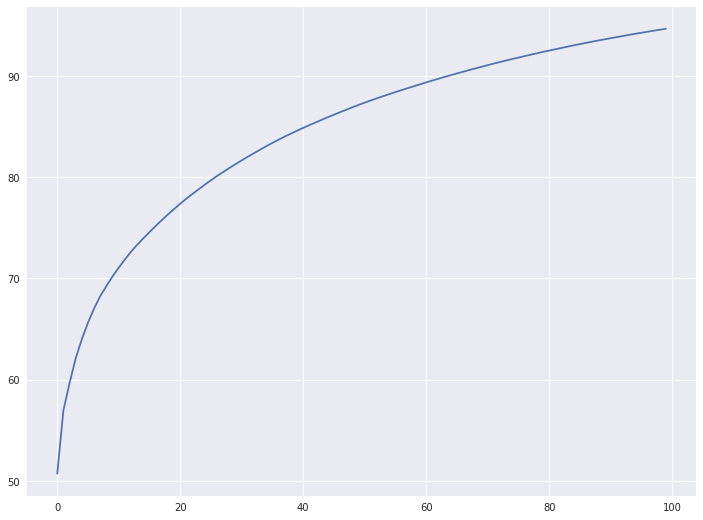

In [107]:
plt.plot(var1);

In [109]:
var1[abs(var1 - 90) < 0.1]
for i in range(np.shape(var1)[0]):
  if (abs(var1[i] - 90) < 0.1):
    print(i+1)
    break

65


**Варианты:**
- 56 
- **65**
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- **51**
- 56
- 61

In [110]:
# Ваш код здесь
var1[0]

50.739999999999995

Визуализируйте данные в проекции на первые две главные компоненты.

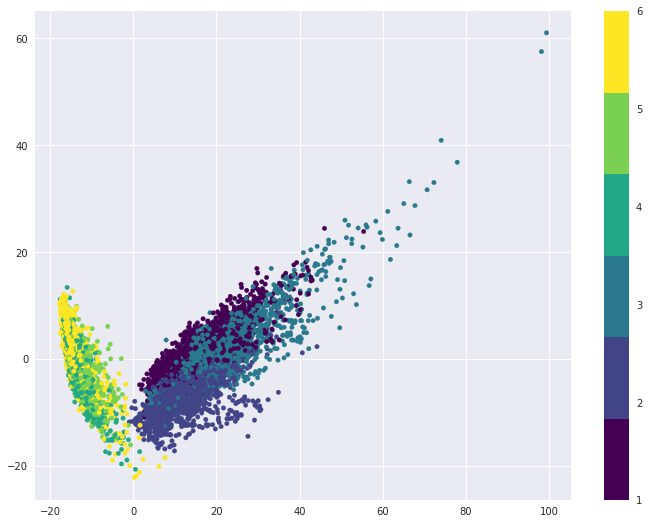

In [118]:
# Ваш код здесь
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap=plt.cm.get_cmap('viridis', 6));
plt.colorbar();

In [0]:
pca = PCA(random_state = RANDOM_STATE, n_components=65)
X_pca = pca.fit_transform(X_scaled)


**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [0]:
# Ваш код здесь
k_means = KMeans(n_clusters = 6, n_init = 100, random_state = RANDOM_STATE)
cluster_labels = k_means.fit_predict(X_pca)

In [145]:
np.shape(K_M)

(10299, 6)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

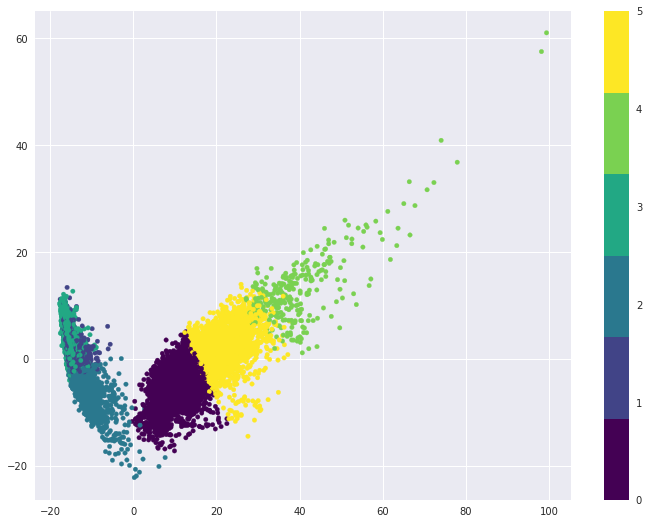

In [152]:

#cluster_labels = ['ходьбе', 'подъему вверх по лестнице', 'спуску по лестнице', 'сидению', 'стоянию', 'лежанию']
#cluster_labels = np.array([[0, 0, 225], [0, 225, 0], [225, 0, 0], [0, 225, 225], [225, 0, 0], [225, 225, 0]])
#cluster_labels = np.array(['g', 'm', 'r', 'b', 'y', 'p'])
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, s=20,  cmap=plt.cm.get_cmap('viridis', 6)
           );
plt.colorbar();

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [153]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,904,0,0,0,78,740,1722
подъем вверх по лестнице,1242,0,2,0,5,295,1544
спуск по лестнице,320,0,0,0,196,890,1406
сидение,1,1235,450,91,0,0,1777
стояние,0,1344,562,0,0,0,1906
лежание,5,53,329,1557,0,0,1944
все,2472,2632,1343,1648,279,1925,10299


In [163]:
clusters = tab.drop('все', axis = 1)
clusters.values.max(axis = 1)/tab.все.values

array([0.52497096, 0.80440415, 0.63300142, 0.69499156, 0.70514166,
       0.80092593, 0.25555879])

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **нет верного ответа**


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

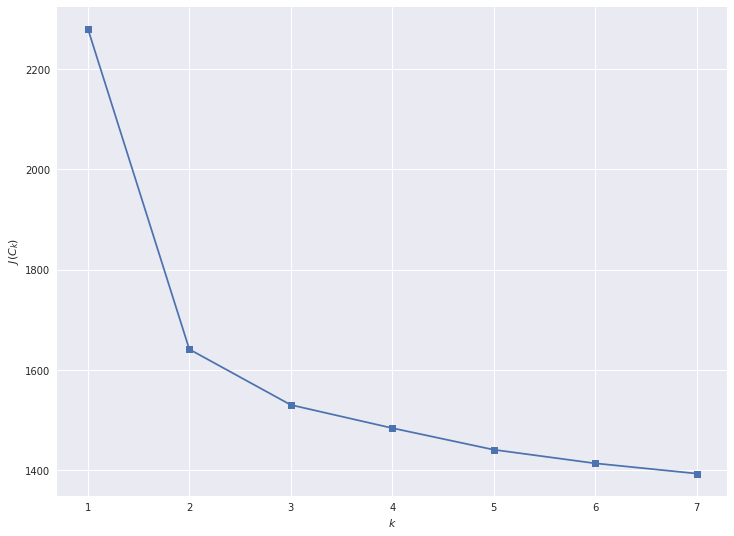

In [171]:
# Ваш код здесь
inertia = []
n_classes = 7
for k in range(1, n_classes + 1):
    #
    kmeans = KMeans(n_clusters=k,  n_init = 100, random_state = RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, n_classes + 1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [0]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit_predict(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [182]:
# Ваш код здесь
k_means_score = metrics.adjusted_rand_score(y, cluster_labels)
ag_score = metrics.adjusted_rand_score(y, ag)
print('KMeans: ', k_means_score, 'AgglomerativeClustering: ', ag_score)

KMeans:  0.4196778456687551 AgglomerativeClustering:  0.48186860900628997


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), примените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [0]:
# Ваш код здесь
scaled = StandardScaler()
X_train_scaled = scaled.fit_transform(X_train)
X_test_scaled = scaled.fit_transform(X_test)

In [0]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [0]:
# Ваш код здесь

best_svc = GridSearchCV(svc, param_grid = svc_params, cv = 3).fit(X_train_scaled, y_train)


In [265]:
best_svc.best_params_

{'C': 0.1}

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [0]:
y_predicted = best_svc.predict(X_test_scaled)

In [232]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,479,11,4,2,0,0,496
подъем вверх по лестнице,4,465,1,1,0,0,471
спуск по лестнице,1,2,416,1,0,0,420
сидение,0,4,0,433,52,2,491
стояние,0,0,0,16,516,0,532
лежание,0,0,0,0,6,531,537
все,484,482,421,453,574,533,2947


In [0]:
svc = LinearSVC(C = 1,random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
y_predicted = svc.predict(X_test_scaled)

In [234]:
precision_score = metrics.precision_score(y_test, y_predicted, average= None)
comleteness_score = metrics.completeness_score(y_test, y_predicted)
print('precision: ', precision_score, 'Completeness: ', comleteness_score)

precision:  [0.99157895 0.95071869 0.98554217 0.93176972 0.91071429 0.99260628] Completeness:  0.8994417658929118


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – стояние, по полноте – сидение **

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


In [0]:
pca = PCA(random_state = RANDOM_STATE, n_components=65)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

In [0]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

best_svc_pca = GridSearchCV(svc, param_grid = svc_params, cv = 3).fit(X_train_pca, y_train)

In [269]:
y_predicted_pca = best_svc_pca.predict(X_test_pca)
y_predicted = best_svc.predict(X_test_scaled)

pca_score = metrics.accuracy_score(y_test, y_predicted_pca)
not_pca_score = metrics.accuracy_score(y_test, y_predicted)
print(pca_score/not_pca_score)

0.32711267605633804


**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком